# Comparison of ASAS-SN SkyPatrol the lightcurve from Aperture photometry lightcurve with those from Image Subtraction (reference flux added)

In [1]:
import sys
if "../" not in sys.path:  # to get my usual helpers at base dir
    sys.path.append("../")

import lightkurve as lk
from lightkurve_ext import of_sector, of_sectors, of_2min_cadences
import lightkurve_ext as lke
from lightkurve_ext import TransitTimeSpec, TransitTimeSpecList
import lightkurve_ext_tess as lket
import lightkurve_ext_pg as lke_pg
import lightkurve_ext_pg_runner as lke_pg_runner
import tic_plot as tplt

import asyncio_compat

import math
import re
import warnings

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplotlib

import pandas as pd
import astropy as astropy
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time, TimeDelta
from astropy.io import fits

from matplotlib.ticker import (FormatStrFormatter, AutoMinorLocator)

from importlib import reload # useful during development to reload packages

from IPython.display import display, HTML, Javascript, clear_output

display(HTML("<style>.container { width:99% !important; }</style>"))  # Jupyter 6
display(HTML("<style>.jp-Notebook { --jp-notebook-max-width: 98%; }</style>"))  # Jupyter 7


# No longer works in Jupyter 7+
display(Javascript("""
// export notebook url to Python for bokeh-based interactive features
if (window["IPython"] != null) {
  IPython.notebook.kernel.execute(`notebook_url = "${window.location.origin}"`);
} else {
  console.warn("IPython js object not available (in Jupyter 7). Hardcode notebook_url in the notebook itself instead.")
}
"""));
notebook_url = "localhost:8888"

%matplotlib inline

# data cache config
lk_download_dir = '../data'
if hasattr(lk, "conf"):  # default download dir
    lk.conf.cache_dir = lk_download_dir

# make markdown table aligned to the left of the cell output (instead of center)
display(HTML("<style>table {margin-left: 4ch;}</style>"))

<IPython.core.display.Javascript object>

- The target is contamianted by a slightly brigher star ~ 3" away.
- The results of Aperture Photomery and Image Subtraction (with reference flux) are comparable.
  - image subtraction does not change the amplitude signficantly (it does not really deblend the data, unlike the subtration done in TESS QLP)
    - if anything, the result appears to have some resemblance of binning, smoothing the outliers
  - ASAS-SN Variable website states that subtraction primiarly can increase the minimum magnitude it can reach. (Maybe 18?)


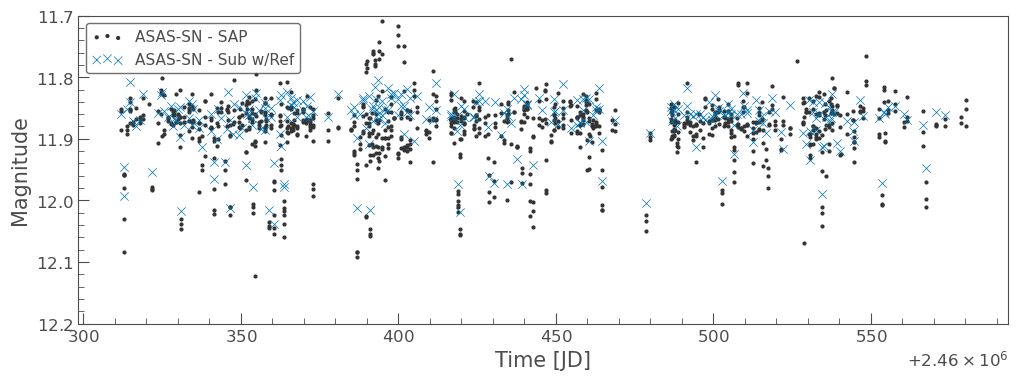

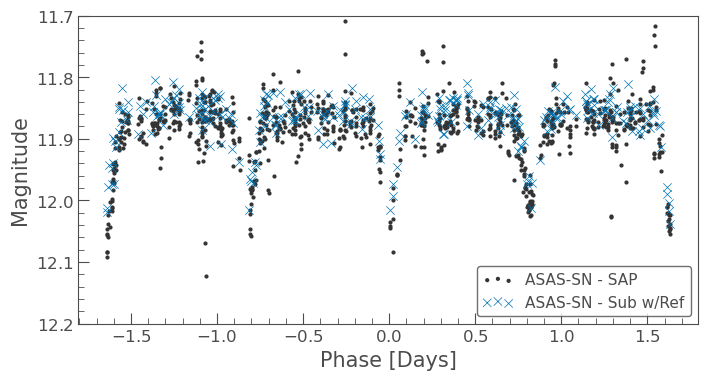

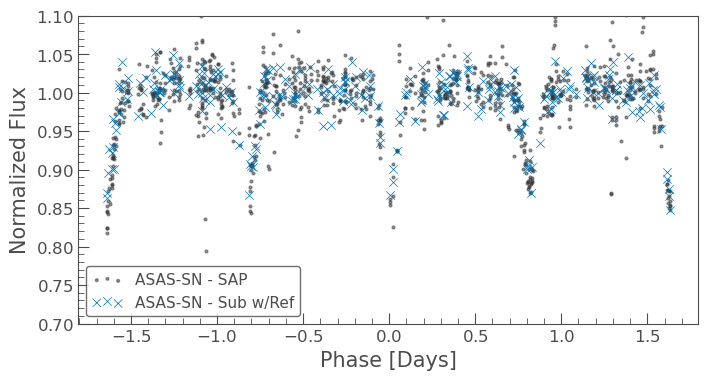

In [25]:
import lightkurve_ext_readers as lker
# reload(lker)

# Target: TIC 1050594841 / Gaia DR3 6093967575460032896
# coord: 210.21844025625 -49.00404146133
period = 1.643038  # MCMC 
epoch_time_hjd = 2457424.345 # MCMC 


# SAP result
# https://asas-sn.osu.edu/sky-patrol/coordinate/f77957a4-27c8-4283-a107-e1fd96a9bebf
# https://asas-sn.osu.edu/sky-patrol/coordinate/f77957a4-27c8-4283-a107-e1fd96a9bebf/export.csv
lc = lker.read_asas_sn_csv(f"{lk_download_dir}/targets/tic1050594841_asas_sn_light_curve_f77957a4-27c8-4283-a107-e1fd96a9bebf.csv")
lc.label = "ASAS-SN - SAP"
lc = lc.truncate(Time("2024-01-01", format="iso").to_value("jd"), Time("2024-12-31", format="iso").to_value("jd"))
lc = lc.select_flux("mag")
lc_sap = lc  # keep the reference in a meaninfgul name for use in subsequent cells

# Image Subtraction with reference flux added
# https://asas-sn.osu.edu/sky-patrol/coordinate/ed7dfe1f-8ec1-4da3-9a74-ed6c515cdcf9
# https://asas-sn.osu.edu/sky-patrol/coordinate/ed7dfe1f-8ec1-4da3-9a74-ed6c515cdcf9/export.csv
lc = lker.read_asas_sn_csv(f"{lk_download_dir}/targets/tic1050594841_asas_sn_img_sub_w_ref_365d_light_curve_ed7dfe1f-8ec1-4da3-9a74-ed6c515cdcf9.csv")
lc.label = "ASAS-SN - Sub w/Ref"
lc = lc.truncate(Time("2024-01-01", format="iso").to_value("jd"), Time("2024-12-31", format="iso").to_value("jd"))
lc = lc.select_flux("mag")
lc_sub_w_ref = lc

ylim = (12.2, 11.7)
ax = tplt.lk_ax(figsize=(12, 4))
ax = tplt.scatter(lc_sap, s=16, ax=ax);
ax = tplt.scatter(lc_sub_w_ref, s=36, marker="x", ax=ax);
# ax.set_title(ax.get_title());
ax.set_ylim(*ylim);

ax2 = tplt.lk_ax(figsize=(8, 4))
ax2 = tplt.scatter(lc_sap.fold(period=period * 2, epoch_time=epoch_time_hjd), s=16, ax=ax2);
ax2 = tplt.scatter(lc_sub_w_ref.fold(period=period * 2, epoch_time=epoch_time_hjd), s=36, marker="x", ax=ax2);
ax2.set_ylim(*ylim);


#
# Now compare the normalized flux (I dont' expact it to be any different)
#

lc = lker.read_asas_sn_csv(f"{lk_download_dir}/targets/tic1050594841_asas_sn_light_curve_f77957a4-27c8-4283-a107-e1fd96a9bebf.csv")
lc.label = "ASAS-SN - SAP"
lc = lc.truncate(Time("2024-01-01", format="iso").to_value("jd"), Time("2024-12-31", format="iso").to_value("jd"))
lc = lc.select_flux("flux").normalize()
lc_sap_n = lc  # keep the reference in a meaninfgul name for use in subsequent cells

lc = lker.read_asas_sn_csv(f"{lk_download_dir}/targets/tic1050594841_asas_sn_img_sub_w_ref_365d_light_curve_ed7dfe1f-8ec1-4da3-9a74-ed6c515cdcf9.csv")
lc.label = "ASAS-SN - Sub w/Ref"
lc = lc.truncate(Time("2024-01-01", format="iso").to_value("jd"), Time("2024-12-31", format="iso").to_value("jd"))
lc = lc.select_flux("flux").normalize()
lc_sub_w_ref_n = lc

ax3 = tplt.lk_ax(figsize=(8, 4))
ax3 = tplt.scatter(lc_sap_n.fold(period=period * 2, epoch_time=epoch_time_hjd), s=16, alpha=0.5, ax=ax3);
ax3 = tplt.scatter(lc_sub_w_ref_n.fold(period=period * 2, epoch_time=epoch_time_hjd), s=36, marker="x", zorder=2, ax=ax3);
ax3.set_ylim(0.70, 1.1);


# print(len(lc), np.nanmedian(lc))  # some basic stats



In [20]:
display(lc_sap)
display(lc_sub_w_ref)
len(lc_sub_w_ref) / len(lc_sap)  # image subtraction will have much less cadence, each epoch usually require 3 images

time,flux,flux_err,hjd,ut_date,camera,fwhm,limit,mag,mag_err,filter
,mag,mag,,,,,,mag,mag,
Time,float64,float64,float64,str18,str2,float64,float64,float64,float64,str1
2460311.82385,11.851,0.008,2460311.82385,2024-01-02.3265932,bl,1.49,15.558,11.851,0.008,g
2460311.82507,11.855,0.008,2460311.82507,2024-01-02.3278208,bl,1.49,15.552,11.855,0.008,g
2460311.82631,11.886,0.008,2460311.82631,2024-01-02.3290554,bl,1.48,15.551,11.886,0.008,g
2460312.82804,12.083,0.009,2460312.82804,2024-01-03.3307163,bG,1.43,15.652,12.083,0.009,g
2460312.82933,12.03,0.009,2460312.82933,2024-01-03.3320123,bG,1.41,15.646,12.03,0.009,g
2460312.8306,11.98,0.009,2460312.8306,2024-01-03.3332872,bG,1.4,15.62,11.98,0.009,g
2460312.85157,11.957,0.009,2460312.85157,2024-01-03.3542478,bl,1.49,15.597,11.957,0.009,g
2460312.8528,11.959,0.009,2460312.8528,2024-01-03.3554767,bl,1.51,15.548,11.959,0.009,g


time,flux,flux_err,hjd,ut_date,camera,fwhm,limit,mag,mag_err,filter
,mag,mag,,,,,,mag,mag,
Time,float64,float64,float64,str18,str2,float64,float64,float64,float64,str1
2460311.82359,11.86,0.001,2460311.82359,2024-01-02.3265932,bl,1.49,17.441,11.86,0.001,g
2460312.82829,11.993,0.003,2460312.82829,2024-01-03.3307163,bG,1.43,16.784,11.993,0.003,g
2460312.85131,11.945,0.002,2460312.85131,2024-01-03.3542478,bl,1.49,17.095,11.945,0.002,g
2460313.85628,11.851,0.002,2460313.85628,2024-01-04.3591484,bH,1.5,16.972,11.851,0.002,g
2460314.82405,11.841,0.002,2460314.82405,2024-01-05.3268608,bl,1.43,17.243,11.841,0.002,g
2460314.83587,11.808,0.001,2460314.83587,2024-01-05.3381685,bk,1.48,17.28,11.808,0.001,g
2460315.86574,11.871,0.003,2460315.86574,2024-01-06.3684700,bl,1.44,16.474,11.871,0.003,g
2460316.54456,11.88,0.002,2460316.54456,2024-01-07.0467299,bo,1.48,17.14,11.88,0.002,g


0.29862475442043224